In [5]:
import polars as pl
from polars import testing
import numpy as np
from fastauc.fastauc.fast_auc import CppAuc

cpp_auc = CppAuc()

In [2]:
evaluation_ds = pl.read_parquet('/home/ubuntu/experiments/wide_deep_predictions.parquet')
behaviors_val = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/validation/behaviors.parquet')
history_val = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/train/history.parquet')

In [3]:
prediction_ds = evaluation_ds.group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))

In [6]:
result = [cpp_auc.roc_auc_score(np.array(y_t).astype(bool), np.array(y_s).astype(np.float32)) 
                for y_t, y_s in zip(prediction_ds['target'].to_list(), 
                                    prediction_ds['prediction'].to_list())]
behaviors_val = behaviors_val.select(['impression_id','impression_time','user_id'])

history_val = history_val.with_columns(
    pl.col('article_id_fixed').list.len().alias('history_len')
).select(['user_id','history_len'])

auc_df = prediction_ds.with_columns(pl.Series(result).alias('AUC'))

auc_df = auc_df.join(behaviors_val, on='impression_id').join(history_val, on='user_id')

In [7]:
from bisect import bisect_left
groups = []
for i in range(1000000):
    groups.append(i*20)
    
def build_closest(groups):
    def take_closest(myNumber):
        """
        Assumes myList is sorted. Returns closest value to myNumber.

        If two numbers are equally close, return the smallest number.
        """
        pos = bisect_left(groups, myNumber)
        if pos == 0:
            return groups[0]
        if pos == len(groups):
            return groups[-1]
        after = groups[pos]
        return after
    return take_closest


build_closest(groups)(250)

260

# MEAN AUC BY HISTORY LEN

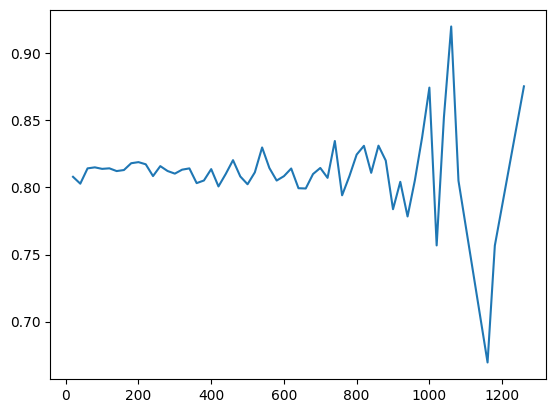

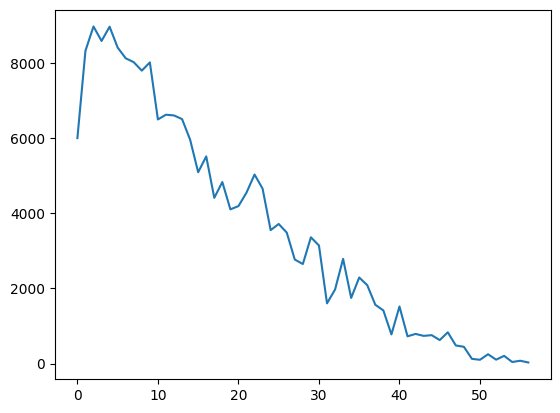

(1160, 0.6696095695582832, 41)
(1180, 0.7566698276110597, 74)
(1020, 0.7567874784767628, 100)
(940, 0.7783562989298044, 831)
(900, 0.7837484512650809, 755)
(760, 0.7941243655031638, 1564)
(660, 0.7992013261486517, 1969)
(640, 0.79939640795278, 1601)
(420, 0.8007221958693583, 4189)
(500, 0.8023380273454626, 3550)
(40, 0.80278116802769, 8323)
(360, 0.8031988358061736, 4410)
(920, 0.8041632190131798, 624)
(1080, 0.8049684430600381, 204)
(580, 0.8051082473121628, 2648)
(960, 0.805142869681058, 481)
(380, 0.8051544399905032, 4830)
(720, 0.8071151618947885, 2289)
(20, 0.8078894779777891, 5999)
(480, 0.8081608595239294, 4654)
(780, 0.8083355406593197, 1413)
(600, 0.8083715794137206, 3359)
(240, 0.8084393316073716, 6622)
(680, 0.809947308544698, 2786)
(440, 0.8100236867238446, 4547)
(300, 0.8102644660117864, 5957)
(840, 0.8108666133886789, 724)
(520, 0.8112105899678486, 3714)
(140, 0.8121652499539205, 8124)
(280, 0.8122234035332005, 6505)
(160, 0.812944449200968, 8019)
(320, 0.8132093230961577

In [8]:
from matplotlib import pyplot as plt
group_auc = auc_df.group_by('history_len').agg(pl.col('AUC').mean()).sort(by='history_len')

group_id = list(map(build_closest(groups), auc_df.select('history_len').to_numpy()))

group_auc = auc_df.with_columns(pl.Series(group_id).alias('group_id')).group_by('group_id').agg(pl.col('AUC').mean()).sort(by='group_id')

plt.plot(group_auc.select('group_id').to_numpy(), group_auc.select('AUC').to_numpy())
plt.show()

plt.plot(auc_df.with_columns(pl.Series(group_id).alias('group_id')).group_by('group_id').len().sort(by='group_id').select('len').to_numpy())
plt.show()

group_auc = auc_df.with_columns(pl.Series(group_id).alias('group_id')).group_by('group_id').agg(pl.col('AUC').mean(), pl.col('user_id'))\
    .with_columns(pl.col('user_id').list.len()).sort(by='AUC')

for row in group_auc.iter_rows():
    print(row)

# MEAN AUC BY DATE

shape: (8, 2)
┌────────────┬──────────┐
│ date       ┆ AUC      │
│ ---        ┆ ---      │
│ date       ┆ f64      │
╞════════════╪══════════╡
│ 2023-05-25 ┆ 0.8204   │
│ 2023-05-26 ┆ 0.824985 │
│ 2023-05-27 ┆ 0.800265 │
│ 2023-05-28 ┆ 0.801053 │
│ 2023-05-29 ┆ 0.804443 │
│ 2023-05-30 ┆ 0.806598 │
│ 2023-05-31 ┆ 0.821501 │
│ 2023-06-01 ┆ 0.839636 │
└────────────┴──────────┘


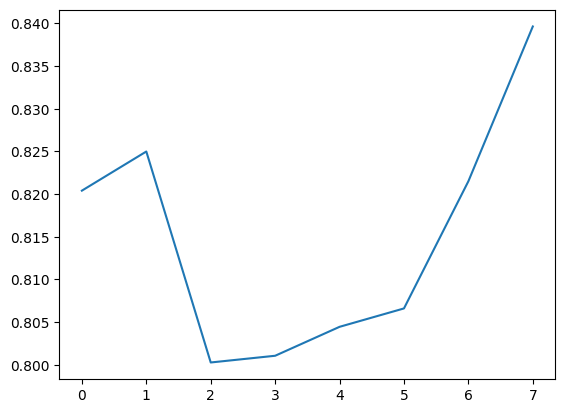

In [9]:
date_df = auc_df.with_columns(pl.col('impression_time').cast(pl.Date).alias('date'))\
    .group_by('date').agg(pl.col('AUC').mean()).sort(by='date')

print(date_df)
plt.plot(date_df.select('AUC').to_numpy())
# plt.xticks(groups)
plt.show()

# MEAN AUC BY HOUR

shape: (24, 2)
┌──────┬──────────┐
│ hour ┆ AUC      │
│ ---  ┆ ---      │
│ i8   ┆ f64      │
╞══════╪══════════╡
│ 0    ┆ 0.791676 │
│ 1    ┆ 0.796412 │
│ 2    ┆ 0.795644 │
│ 3    ┆ 0.807823 │
│ 4    ┆ 0.814648 │
│ …    ┆ …        │
│ 19   ┆ 0.807346 │
│ 20   ┆ 0.822425 │
│ 21   ┆ 0.807347 │
│ 22   ┆ 0.788682 │
│ 23   ┆ 0.78998  │
└──────┴──────────┘


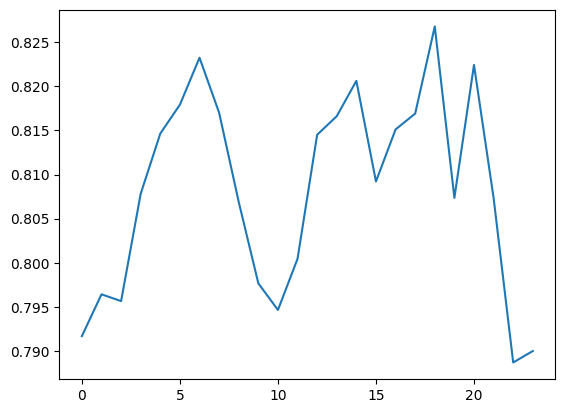

In [10]:
hour_df = auc_df.with_columns(pl.col('impression_time').dt.hour().alias('hour'))\
    .group_by('hour').agg(pl.col('AUC').mean()).sort(by='hour')

print(hour_df)
plt.plot(hour_df.select('AUC').to_numpy())
# plt.xticks(groups)
plt.show()